In [1]:
############# LOAD LIBRARIES #############
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import random 
from PIL import Image
from keras.utils import Progbar
from timeit import default_timer as timer
import pandas as pd

######## INITIALIZE DATASET DIRECTORIES ########
DATASET_NAME = ''
DATASET_DIR = "../datasets/" + DATASET_NAME
TRAIN_DIR = DATASET_DIR + 'CoILTrain'
VAL_DIR = DATASET_DIR + 'CoILVal1'
TEST_DIR = DATASET_DIR + 'CoILVal2'
TOWN3_DIR = DATASET_DIR + 'CoILTrainTown03'

Using TensorFlow backend.


In [2]:
######## CHECK AVAILABLE DATA ########
episode_list = []
#  
directories = [TRAIN_DIR, VAL_DIR, TEST_DIR]
for directory in directories:
    for item in os.listdir(directory):
        if 'episode' in item:
            #print(item, len(os.listdir(TRAIN_DIR + '/' + item)))
            episode_list.append(directory + '/' + item)
        elif 'metadata' in item:
            with open(directory + '/' + item) as f:
                metadata = json.loads(f.read())
print("Total Episodes:", len(episode_list))
episode_list[:5]

Total Episodes: 42


['../datasets/CoILTrain/episode_00003',
 '../datasets/CoILTrain/episode_00018',
 '../datasets/CoILTrain/episode_00012',
 '../datasets/CoILTrain/episode_00000',
 '../datasets/CoILTrain/episode_00010']

In [3]:
######## FIND IMAGE AND JSON DATA FILES ########
x_data_files, y_data_files = [], []
camera_text = 'CentralRGB_'
measurement_text = 'measurements'
for ep in episode_list:
    files = os.listdir(ep)
    for file in files:
        if camera_text in file:
            x_data_files.append(ep + '/' + file)
        if measurement_text in file:
            y_data_files.append(ep + '/' + file)
            
x_data_files = sorted(x_data_files)
y_data_files = sorted(y_data_files)

print("X length:", len(x_data_files), "| Sample:", x_data_files[0])
print("Y length:", len(y_data_files), "| Sample:", y_data_files[0])

if len(x_data_files) != len(y_data_files):
    print("Warning: X and Y data files do not have the same length. Please fix it before proceeding!")

X length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/CentralRGB_00000.png
Y length: 77107 | Sample: ../datasets/CoILTrain/episode_00000/measurements_00000.json


In [4]:
################## PROCESSING INPUT DATA ######################
FRAME_BATCH = 6  # number of frames and respective data is clumped together
N = len(x_data_files) - len(x_data_files) % FRAME_BATCH # get rid of extra data that doesn't fit in batch
x_data_camera = np.zeros((N, 88, 200, 3)).astype('uint8')
x_data_speed = np.zeros(N)
x_data_direction = np.zeros(N)
    
y_steer    = np.zeros(N)
y_throttle = np.zeros(N)
y_brake    = np.zeros(N)

stop_pedestrian = np.zeros(N)
stop_traffic_lights = np.zeros(N)
stop_vehicle = np.zeros(N)

pos_x = np.zeros(N)
pos_y = np.zeros(N)
pos_z = np.zeros(N)

print("Extracting images ...")
start = timer()
progbar = Progbar(target=N, verbose=1)
for index, image in enumerate(x_data_files):
    if index < N:
        x_data_camera[index] = np.array(Image.open(image)).astype('uint8')
        progbar.update(index)
    else:
        break
end = timer()
print("\nExtracted images (in {:.2f} seconds).".format(end-start))    

print("Extracting measurements ...")   
start = timer()
progbar = Progbar(target=N, verbose=1)
for index, jsn in enumerate(y_data_files):
    if index < N:
        with open(jsn) as f:
            measurements = json.loads(f.read())
        x_data_direction[index] = measurements['directions']
        y_steer[index] = measurements['steer']
        y_throttle[index] = measurements['throttle']
        y_brake[index] = measurements['brake']
        
        stop_pedestrian[index] = measurements['stop_pedestrian']      
        stop_traffic_lights[index] = measurements['stop_traffic_lights'] 
        stop_vehicle[index] = measurements['stop_vehicle'] 
        
        pos_x[index] = measurements['playerMeasurements']['transform']['location']['x']
        pos_y[index] = measurements['playerMeasurements']['transform']['location']['y']
        pos_z[index] = measurements['playerMeasurements']['transform']['location']['z']
        try:
            x_data_speed[index] = measurements['playerMeasurements']['forwardSpeed']        
        except:
            x_data_speed[index] = 0 # if forward speed not found, use speed = 0
        progbar.update(index)
    else:
        break 
y_data = np.array([y_steer, y_throttle, y_brake]).T
del y_steer, y_throttle, y_brake
end = timer()
print("\nExtracted measurements (in {:.2f} seconds).".format(end-start))    

print("X:", x_data_camera.shape, x_data_direction.shape, x_data_speed.shape)
print("Y:", y_data.shape)

Extracting images ...
77105/77106 [============================>.] - ETA: 0s
Extracted images (in 600.34 seconds).
Extracting measurements ...
77097/77106 [============================>.] - ETA: 0s
Extracted measurements (in 912.52 seconds).
X: (77106, 88, 200, 3) (77106,) (77106,)
Y: (77106, 3)


In [5]:
############# CHANGE VOID DIRECTION TO LANE FOLLOW #############
x_data_direction[x_data_direction == 0] = 2

# ############# NORMALIZE SPEED #############
x_data_speed = x_data_speed / 12
x_data_speed[x_data_speed < 0] = 0
print("Speed (max, min)", max(x_data_speed), min(x_data_speed))

############# NORMALIZE STEER #############
y_data[:, 0][y_data[:, 0] > 0.] = y_data[:, 0][y_data[:, 0] > 0.] / (np.max(y_data[:, 0]))
y_data[:, 0][y_data[:, 0] < 0.] = y_data[:, 0][y_data[:, 0] < 0.] / (-np.min(y_data[:, 0]))
print("Steer (max, min)", max(y_data[:, 0]), min(y_data[:, 0]))

Speed (max, min) 0.8969029585520426 0.0
Steer (max, min) 1.0 -1.0


Text(0.5,0,'[2.0, 0.7948995431264242]')

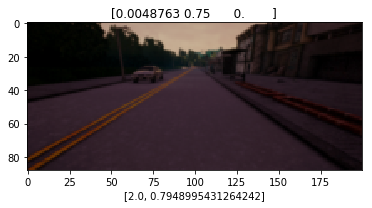

In [6]:
############# SANITY CHECK #############
frame = 125
plt.imshow(x_data_camera[frame])
plt.title(y_data[frame])
plt.xlabel([x_data_direction[frame], x_data_speed[frame]])

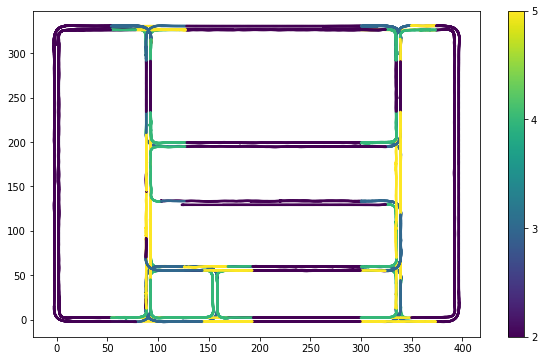

In [7]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(10, 6))
# cmap = mpl.colors.ListedColormap(['indigo', 'firebrick', 'royalblue', 'forestgreen'])
plt.scatter(pos_x, pos_y, 
           c=x_data_direction, s=2)
# plt.scatter(pos_x[range_start:range_end], pos_y[range_start:range_end], 
#             c=stop_traffic_lights[range_start:range_end])
plt.colorbar(ticks=[2, 3, 4, 5])

Text(0.5,1,'Brake Histogram')

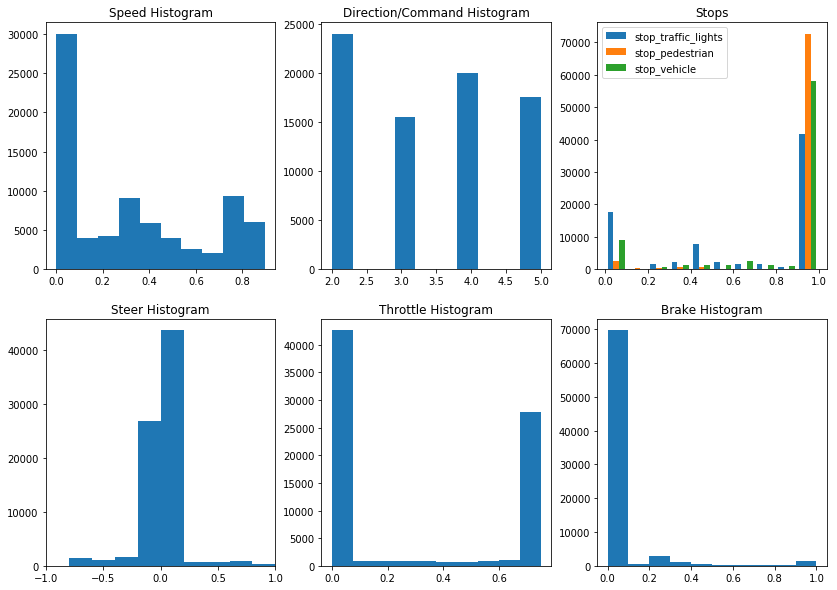

In [8]:
############# VISUALIZATION OF DATA DISTRIBUTION #############

fig, ax = plt.subplots(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.hist(x_data_speed, 10)
plt.title('Speed Histogram')

plt.subplot(2, 3, 2)
plt.hist(x_data_direction)
plt.title('Direction/Command Histogram')

plt.subplot(2, 3, 3)
plt.hist([stop_traffic_lights, stop_pedestrian, stop_vehicle])
plt.title('Stops')
plt.legend(['stop_traffic_lights', 'stop_pedestrian', 'stop_vehicle'])

plt.subplot(2, 3, 4)
plt.hist(y_data[:,0], 10)
plt.xlim([-1 ,1])
plt.title('Steer Histogram')

plt.subplot(2, 3, 5)
plt.hist(y_data[:,1], 10)
plt.title('Throttle Histogram')

plt.subplot(2, 3, 6)
plt.hist(y_data[:,2], 10)
plt.title('Brake Histogram')

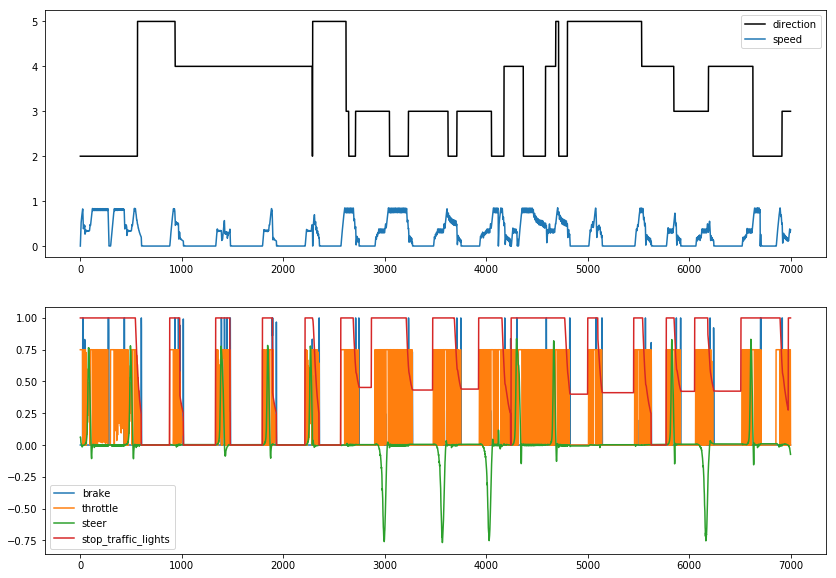

In [9]:
################## VISUALIZE CONTROL COMMANDS ######################
range_start, range_end = 0, 7000

# 2 - follow lane
# 3 - left
# 4 - right
# 5 - straight

fig, ax = plt.subplots(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(x_data_direction[range_start:range_end], '-k', label='direction')
plt.plot(x_data_speed[range_start:range_end], label='speed')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_data[range_start:range_end,2], label='brake')
plt.plot(y_data[range_start:range_end,1], label='throttle')
plt.plot(y_data[range_start:range_end,0], label='steer')
# plt.plot(x_data_direction[range_start:range_end], '-k', label='direction') 
plt.plot(stop_traffic_lights[range_start:range_end], label='stop_traffic_lights')
plt.legend()


Text(0.5,1,'[1.0, 0.0]')

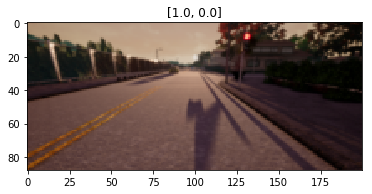

In [10]:
frame = 1200
plt.imshow(x_data_camera[frame])
plt.title([np.floor(1-stop_traffic_lights[frame]), np.floor(1-stop_vehicle[frame])])

In [8]:
############# SAMPLING DATA AT SOME FPS #############
skip = True
if skip:
    FPS = 2
    x_data_camera = x_data_camera[::FPS]
    x_data_speed = x_data_speed[::FPS]
    x_data_direction = x_data_direction[::FPS]
    y_data = y_data[::FPS]
    
    stop_pedestrian     = stop_pedestrian[::FPS]
    stop_traffic_lights = stop_traffic_lights[::FPS]
    stop_vehicle        = stop_vehicle[::FPS]

    pos_x = pos_x[::FPS]
    pos_y = pos_y[::FPS]
    pos_z = pos_z[::FPS]
    print("Removed {:0.2f}% of frames.".format(1/FPS * 100))
else:
    print("Did not skip frames.")

Removed 50.00% of frames.


In [11]:
############# SPLIT DATA TO TRAINING AND TEST SETS #############
from sklearn.model_selection import ShuffleSplit, train_test_split

SPLIT_RATIO = 0.8
SHUFFLE = True

try:
    if not SHUFFLE:
        split = int(len(y_data) * SPLIT_RATIO)
        x_train_camera, x_test_camera = x_data_camera[:split], x_data_camera[split+1:]
        x_train_speed, x_test_speed = x_data_speed[:split], x_data_speed[split+1:]
        x_train_direction, x_test_direction = x_data_direction[:split], x_data_direction[split+1:]
        
        x_train_stop_pedestrian, x_test_stop_pedestrian = stop_pedestrian[:split], stop_pedestrian[split+1:]
        x_train_stop_traffic_lights, x_test_stop_traffic_lights = stop_traffic_lights[:split], stop_traffic_lights[split+1:]
        x_train_stop_vehicle, x_test_stop_vehicle = stop_vehicle[:split], stop_vehicle[split+1:]
        
        y_train, y_test = y_data[:split], y_data[split+1:]
    else:
        indices = np.arange(len(y_data))
        x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(indices, indices, test_size=0.25)
        
        x_train_camera = x_data_camera[x_train_ind, :, :, 0:3]
        x_test_camera = x_data_camera[x_test_ind, :, :, 0:3]
        
        x_train_speed = x_data_speed[x_train_ind]
        x_test_speed = x_data_speed[x_test_ind]
        
        x_train_direction = x_data_direction[x_train_ind]
        x_test_direction = x_data_direction[x_test_ind]
        
        x_train_stop_pedestrian, x_test_stop_pedestrian = stop_pedestrian[x_train_ind], stop_pedestrian[x_test_ind]
        x_train_stop_traffic_lights, x_test_stop_traffic_lights = stop_traffic_lights[x_train_ind], stop_traffic_lights[x_test_ind]
        x_train_stop_vehicle, x_test_stop_vehicle = stop_vehicle[x_train_ind], stop_vehicle[x_test_ind]
        
        y_train = y_data[y_train_ind, :]
        y_test = y_data[y_test_ind, :]
        del indices
        del x_train_ind, x_test_ind, y_train_ind, y_test_ind
except Error as E:
    print(E)
    print("x_data_* and y_data values are empty. Using previously stored values.")
    
print("Train Shape | x_train_camera:", x_train_camera.shape, "\t| x_train_camera:", x_train_speed.shape,
      "\t| y_train:", y_train.shape)
print(" Test Shape | x_test_camera:", x_test_camera.shape, "\t| x_test_speed:", x_test_speed.shape, 
      "\t| y_test:", y_test.shape)

Train Shape | x_train_camera: (57829, 88, 200, 3) 	| x_train_camera: (57829,) 	| y_train: (57829, 3)
 Test Shape | x_test_camera: (19277, 88, 200, 3) 	| x_test_speed: (19277,) 	| y_test: (19277, 3)


(array([44767.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13062.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

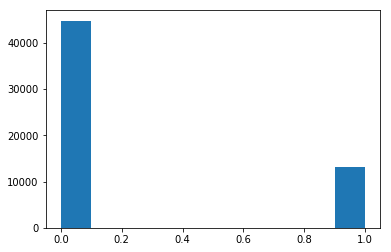

In [12]:
x_train_stop_pedestrian      = np.array(x_train_stop_pedestrian==0, dtype=int)
x_test_stop_pedestrian       = np.array(x_test_stop_pedestrian==0, dtype=int)
x_train_stop_traffic_lights  = np.array(x_train_stop_traffic_lights==0, dtype=int)
x_test_stop_traffic_lights   = np.array(x_test_stop_traffic_lights==0, dtype=int)
x_train_stop_vehicle         = np.array(x_train_stop_vehicle==0, dtype=int)
x_test_stop_vehicle          = np.array(x_test_stop_vehicle==0, dtype=int)
plt.hist(x_train_stop_traffic_lights)

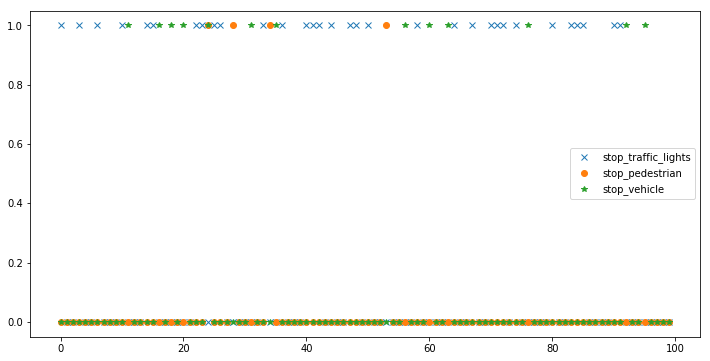

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(x_train_stop_traffic_lights[:100], 'x', label='stop_traffic_lights')
plt.plot(x_train_stop_pedestrian[:100], 'o', label='stop_pedestrian')
plt.plot(x_train_stop_vehicle[:100], '*', label='stop_vehicle')
plt.legend()

1 0 0


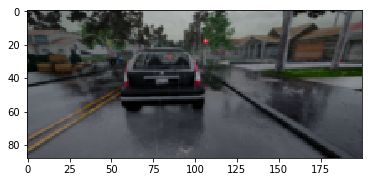

In [27]:
sample = 35
plt.imshow(x_train_camera[sample, :, :, :])
print(x_train_stop_vehicle[sample], x_train_stop_pedestrian[sample], 
     x_train_stop_traffic_lights[sample])

(array([16929.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2348.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

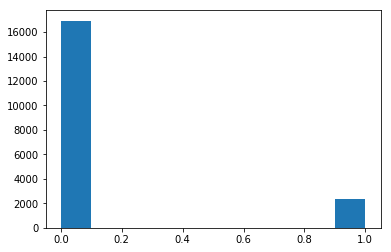

In [28]:
plt.hist(x_test_stop_vehicle)

Text(0.5,1,'1 0 0')

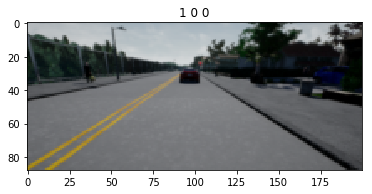

In [30]:
frame = 580
plt.imshow(x_train_camera[frame])
title = str(int(x_train_stop_traffic_lights[frame]==0.0)) +' ' +str(x_train_stop_vehicle[frame]) + ' ' +str(x_train_stop_pedestrian[frame])
plt.title(title)

In [14]:
###### IMAGE AUGMENTATION #######

import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

st = lambda aug: iaa.Sometimes(0.4, aug)
oc = lambda aug: iaa.Sometimes(0.3, aug)
rl = lambda aug: iaa.Sometimes(0.09, aug)
seq = iaa.Sequential([
        rl(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 1.5
        rl(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5)), # add gaussian noise to images
        oc(iaa.Dropout((0.0, 0.10), per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.CoarseDropout((0.0, 0.10), size_percent=(0.08, 0.2),per_channel=0.5)), # randomly remove up to X% of the pixels
        oc(iaa.Add((-40, 40), per_channel=0.2)), # change brightness of images (by -X to Y of original value)
#         st(iaa.Multiply((0.10, 1.5), per_channel=0.2)), # change brightness of images (X-Y% of original value)
        rl(iaa.ContrastNormalization((0.5, 1.5), per_channel=0.5)), # improve or worsen the contrast
        #rl(iaa.Grayscale((0.0, 1))), # put grayscale
], random_order=True)

DATA_AUGMENT_MULTIPLIER = 1
N, IMG_H, IMG_W, IMG_CH = x_train_camera.shape
x_train_camera_aug = np.zeros((N*DATA_AUGMENT_MULTIPLIER, IMG_H, IMG_W, IMG_CH))
x_train_stop_pedestrian_aug = np.zeros(N)
x_train_stop_traffic_lights_aug = np.zeros(N)
x_train_stop_vehicle_aug = np.zeros(N)
y_train_aug = np.zeros((N*DATA_AUGMENT_MULTIPLIER))

max_epoch = len(x_train_camera)


import random
def decision(probability):
    return random.random() <= probability

ctr = 0
images_augmented = 0

while ctr < len(x_train_camera_aug):
    progbar = Progbar(target=max_epoch, verbose=1)
    for i in range(max_epoch):
        if x_train_stop_pedestrian[i] == 1: # pedestrian
            probability = 0.9
        elif x_train_stop_vehicle[i] == 1:  # vehicle ahead
            probability = 0.8
        elif x_train_stop_traffic_lights[i] == 1: # traffic light ahead
            probability = 0.8
        else:
            probability = 0.1
    #         probability = 0
        if decision(probability):
            x_train_camera_aug[ctr] = seq.augment_images(x_train_camera[i:i+1, :, :, :])
            x_train_stop_pedestrian_aug[ctr] = x_train_stop_pedestrian[i]
            x_train_stop_traffic_lights_aug[ctr] = x_train_stop_traffic_lights[i]
            x_train_stop_vehicle_aug[ctr] = x_train_stop_vehicle[i]
#             y_train_aug[ctr] =  y_train[i]
            images_augmented += 1
            ctr += 1
        if ctr >= len(x_train_camera_aug):
            break
        progbar.update(i)
    print("\n")
    print("Images augmented", images_augmented)
# plt.hist(y_train_aug[:images_augmented], 40)
# plt.show()
print("Images Augmented", images_augmented)

57775/57829 [============================>.] - ETA: 0s

Images augmented 21103
57787/57829 [============================>.] - ETA: 0s

Images augmented 41959
43979/57829 [=====================>........] - ETA: 10s

Images augmented 57829
Images Augmented 57829


In [15]:
np.max(x_train_camera), np.max(x_train_camera_aug)

(255, 255.0)

(array([42514.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15315.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

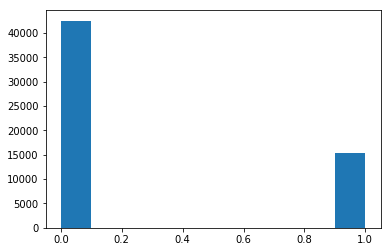

In [16]:
plt.hist(x_train_stop_vehicle_aug)

(57829, 88, 200, 3) (57829, 88, 200, 3)


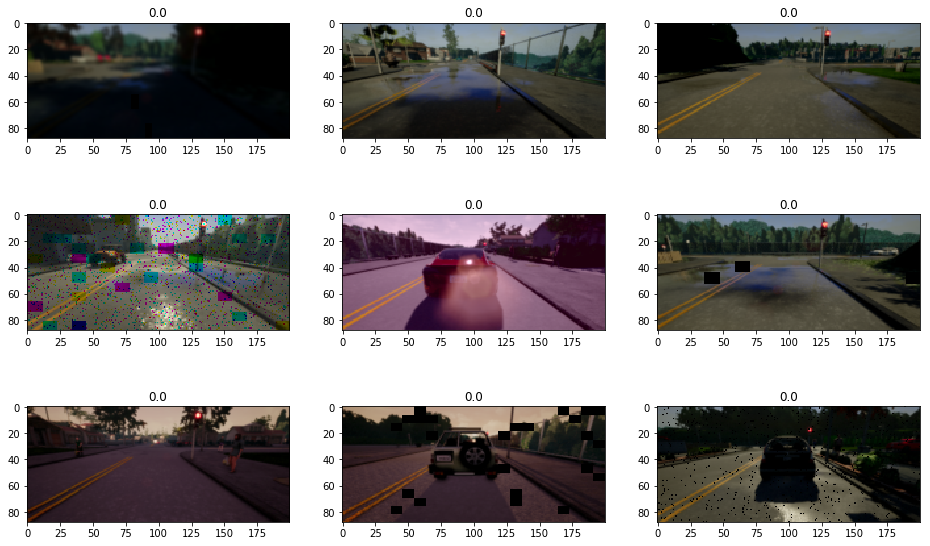

In [17]:
# fig, ax = plt.subplots(figsize=(16, 10))

print(x_train_camera.shape, x_train_camera_aug.shape)
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.title(y_train[i])
#     plt.imshow(x_train_camera[i])
    
fig, ax = plt.subplots(figsize=(16, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.title(y_train_aug[i])
    plt.imshow(x_train_camera_aug[i]/255.0)  

In [18]:
x_train_camera = np.concatenate((x_train_camera, x_train_camera_aug))
x_train_stop_pedestrian = np.concatenate((x_train_stop_pedestrian, x_train_stop_pedestrian_aug))
x_train_stop_traffic_lights = np.concatenate((x_train_stop_traffic_lights, x_train_stop_traffic_lights_aug))
x_train_stop_vehicle = np.concatenate((x_train_stop_vehicle, x_train_stop_vehicle_aug))

(array([14807.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4470.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

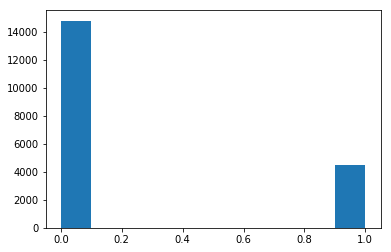

In [19]:
plt.hist(x_test_stop_traffic_lights)

In [20]:
x_train_camera.shape, x_train_stop_pedestrian.shape,x_train_stop_traffic_lights.shape, x_train_stop_vehicle.shape

((115658, 88, 200, 3), (115658,), (115658,), (115658,))

In [21]:
del x_train_camera_aug, x_data_camera

In [23]:
import torch
x_train_camera = x_train_camera / 255.0
x_test_camera = x_test_camera / 255.0

x_train_camera = torch.from_numpy(x_train_camera).permute(0, 3, 1, 2).type(torch.FloatTensor)
x_test_camera = torch.from_numpy(x_test_camera).permute(0, 3, 1, 2).type(torch.FloatTensor)

x_train_stop_traffic_lights = torch.from_numpy(x_train_stop_traffic_lights).type(torch.FloatTensor).reshape(-1, 1)
x_test_stop_traffic_lights = torch.from_numpy(x_test_stop_traffic_lights).type(torch.FloatTensor).reshape(-1, 1)

x_train_stop_vehicle = torch.from_numpy(x_train_stop_vehicle).type(torch.FloatTensor).reshape(-1, 1)
x_test_stop_vehicle = torch.from_numpy(x_test_stop_vehicle).type(torch.FloatTensor).reshape(-1, 1)

x_train_stop_pedestrian = torch.from_numpy(x_train_stop_pedestrian).type(torch.FloatTensor).reshape(-1, 1)
x_test_stop_pedestrian = torch.from_numpy(x_test_stop_pedestrian).type(torch.FloatTensor).reshape(-1, 1)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# previous keras model
# model.add(Conv2D(32, (3, 3), padding='same',
#                  input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('softmax'))

class HazardModel(nn.Module):
    def __init__(self):
        super(HazardModel, self).__init__()
        # input_dim = (3,88,200)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
        )   
        self.fc1 = nn.Sequential(
            nn.Linear(84800, 512),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        stop_traffic_light, stop_vehicle, stop_pedestrian = out[:, 0], out[:, 1], out[:, 2]
        
        return stop_traffic_light, stop_vehicle, stop_pedestrian

In [90]:
#del model

In [93]:
import torch
if torch.cuda.device_count() > 1:
    num_of_gpus = torch.cuda.device_count()
    print("We've got", num_of_gpus, "GPUs.")
    model = nn.DataParallel(model)

We've got 2 GPUs.


In [94]:
load_old_model = False
if load_old_model:
    model_path = 'torch_models/hazard_models/Jane_hazard_v1_25'
    model.load_state_dict(torch.load(model_path))
    print("Loaded", model_path)

In [95]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [96]:
model.to(device)

DataParallel(
  (module): HazardModel(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout2d(p=0.25)
    )
    (layer3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace)
    )
    (layer4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout2d(p=0.25)
    )
    (fc1): Sequential(
      (0): Linear(in_features=84800, out_features=512, bias=True)
      (1): Dropout(p=0.5)
      (2): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_features=512,

In [97]:
import torch.optim as optim

criterion_stop_traffic_light = nn.BCELoss()
criterion_stop_vehicle = nn.BCELoss()
criterion_stop_pedestrian = nn.BCELoss()

weight_stop_traffic_light, weights_stop_vehicle, weight_stop_pedestrian = 0.3, 0.3, 0.4
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
for g in optimizer.param_groups:
    g['lr'] = learning_rate

In [98]:
import torch.utils.data

batch_size = 180 * num_of_gpus
test_batch_size = 100 * num_of_gpus

train_indices = list(range(0, len(x_train_camera)))
train_loader = torch.utils.data.DataLoader(
    (train_indices),
    batch_size= batch_size, shuffle=True)

test_indices = list(range(0, len(x_test_camera)))
test_loader = torch.utils.data.DataLoader(
    (test_indices),
    batch_size= test_batch_size, shuffle=False)

In [89]:
# loss = []
# for i, batch_index in enumerate(train_loader):
#     input_image = torch.from_numpy(x_train_camera[batch_index]/255.0).permute(0,3,1,2).type(torch.FloatTensor)
#     output = torch.from_numpy(x_train_stop_traffic_lights[batch_index]).type(torch.FloatTensor).reshape(-1, 1)
#     optimizer.zero_grad()
#     pred = net(input_image)
#     print(output.size(), pred.size())
#     loss = criterion(pred, output)
#     loss.backward()
#     optimizer.step()
#     break
# print(loss)

torch.Size([180, 64, 25, 53])
torch.Size([180, 84800])
torch.Size([180, 1]) torch.Size([180, 1])
tensor(0.6908, grad_fn=<BinaryCrossEntropyBackward>)


In [99]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss_history = []
    for batch_idx, (indices) in enumerate(train_loader):
        
        # get current batch: images, directions, speeds, ground truth
        img_batch       = x_train_camera[indices].to(device)
        target_stop_traffic_light_batch = x_train_stop_traffic_lights[indices].to(device)
        target_stop_vehicle_batch       = x_train_stop_vehicle[indices].to(device)
        target_stop_pedestrian_batch    = x_train_stop_pedestrian[indices].to(device)

        # zero the gradient to prevent grad accumulation
        optimizer.zero_grad()
        
        # forward propogate the traning batch
#         pred_batch = model(img_batch)
        pred_stop_traffic_light, pred_stop_vehicle, pred_stop_pedestrian = model(img_batch)
        
        # calculate the loss
#         loss = criterion(pred_batch, target_batch)
        loss_stop_traffic_light = criterion_stop_traffic_light(pred_stop_traffic_light.reshape(-1, 1), 
                                                               target_stop_traffic_light_batch)
        loss_stop_pedestrian = criterion_stop_pedestrian(pred_stop_pedestrian.reshape(-1, 1), 
                                                         target_stop_pedestrian_batch)
        loss_stop_vehicle = criterion_stop_vehicle(pred_stop_vehicle.reshape(-1, 1), 
                                                   target_stop_vehicle_batch)
        
        # loss weights
        loss = loss_stop_traffic_light * weight_stop_traffic_light + \
                loss_stop_vehicle * weights_stop_vehicle + \
                loss_stop_pedestrian * weight_stop_pedestrian
        
        # append training loss for later plotting
        train_loss_history.append(loss.item())
        
        # backward propogation.
        loss.backward(loss)
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img_batch), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(train_loss_history)

In [101]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    loss_history = []
    with torch.no_grad():
        for batch_idx, (indices) in enumerate(test_loader):
            
            # get current batch: images, directions, speeds, ground truth
            img_batch       = x_test_camera[indices].to(device)
            target_stop_traffic_light_batch = x_test_stop_traffic_lights[indices].to(device)
            target_stop_vehicle_batch       = x_test_stop_vehicle[indices].to(device)
            target_stop_pedestrian_batch    = x_test_stop_pedestrian[indices].to(device)
        
            # forward propogate the traning batch
            pred_stop_traffic_light, pred_stop_vehicle, pred_stop_pedestrian = model(img_batch)
            print(pred_stop_traffic_light.size(), type(pred_stop_traffic_light))
            # calculate the loss
            loss_stop_traffic_light = criterion_stop_traffic_light(pred_stop_traffic_light.reshape(-1, 1), 
                                                               target_stop_traffic_light_batch)
            loss_stop_pedestrian = criterion_stop_pedestrian(pred_stop_pedestrian.reshape(-1, 1), 
                                                             target_stop_pedestrian_batch)
            loss_stop_vehicle = criterion_stop_vehicle(pred_stop_vehicle.reshape(-1, 1), 
                                                       target_stop_vehicle_batch)
        
            # loss weights
            loss = loss_stop_traffic_light * weight_stop_traffic_light + \
                    loss_stop_vehicle * weights_stop_vehicle + \
                    loss_stop_pedestrian * weight_stop_pedestrian

            # loss weights
            loss_history.append(loss.item())

    print('\nTest set: Average loss: {:.4f}\n'.format(np.mean(loss_history)))
    return np.mean(loss_history)

In [102]:
test_loss_history  = []
train_loss_history = []

In [103]:
torch.cuda.empty_cache()

In [104]:
import time

In [105]:
log_interval = 10
epochs = 100
start_time = time.time() ## starting time
for epoch in range(0, epochs + 1):
    epoch_start_time = time.time()
    train_loss_history.append(train(model, device, train_loader, optimizer, epoch))
    test_loss_history.append(test(model, device, test_loader))
    epoch_end_time = time.time() - epoch_start_time
    print("Elapsed time (s) for epoch {}: {} seconds".format(epoch, epoch_end_time))
    if epoch % 25 == 0:
        CURR_MODEL_PATH = './torch_models/hazard_models/Jane_hazard_v3_{}'.format(epoch)
        torch.save(model.state_dict(), CURR_MODEL_PATH)
        print("Saved", CURR_MODEL_PATH)
    print("*"*50)
end_time = time.time() - start_time
print("Total Elapsed time in Hours: {} hours".format(end_time / 3600))

Train Epoch: 0 [0/115658 (0%)]	Loss: 0.699800


RuntimeError: CUDA out of memory. Tried to allocate 166.00 MiB (GPU 0; 7.77 GiB total capacity; 6.37 GiB already allocated; 26.50 MiB free; 588.37 MiB cached)

In [1]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Val Loss')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

NameError: name 'plt' is not defined

### Visualize results

In [82]:
model.eval()
preds_traffic_light = []
preds_vehicle = []
preds_pedestrian = []
iters = 1000
# iters = len(y_test)
for i in range(iters):
    image = x_test_camera[i:i+1]
#     image = torch.from_numpy(image.reshape(1,3,88,200)).type('torch.cuda.FloatTensor')
    image = image.to(device)
    
    # Forward pass
    optimizer.zero_grad()
    pred_stop_traffic_light, pred_stop_vehicle, pred_stop_pedestrian = model(image)
    preds_traffic_light.append(pred_stop_traffic_light.cpu().detach().numpy())
    preds_vehicle.append(pred_stop_vehicle.cpu().detach().numpy())
    preds_pedestrian.append(pred_stop_pedestrian.cpu().detach().numpy())

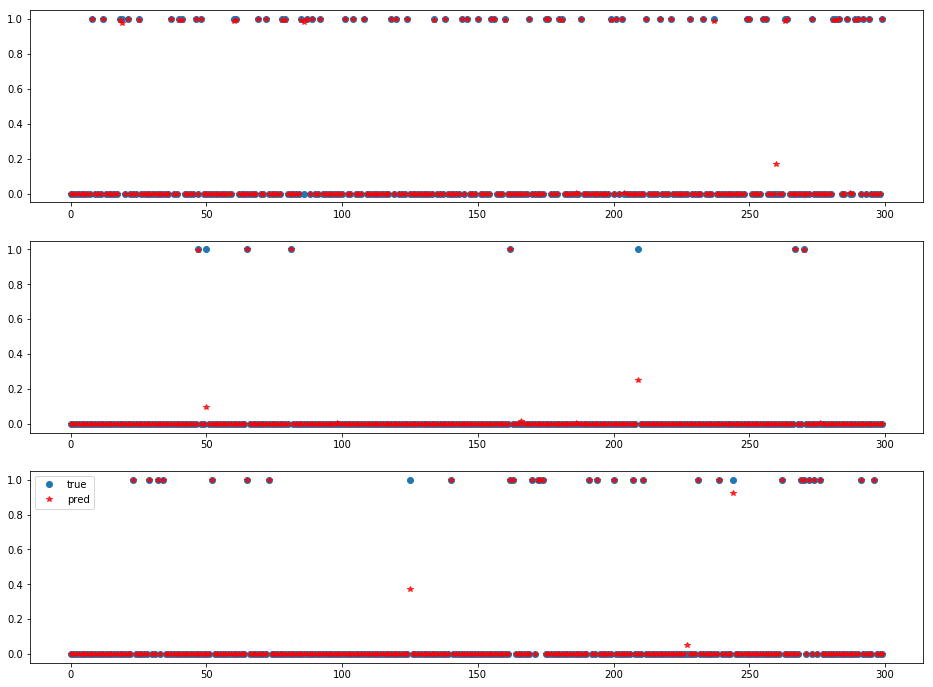

In [95]:
iters = 300
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(x_test_stop_traffic_lights[:iters].numpy(),'o', label='true')
plt.plot(preds_traffic_light[:iters], 'r*', label='pred', alpha=0.8)
plt.subplot(3, 1, 2)
plt.plot(x_test_stop_pedestrian[:iters].numpy(),'o', label='true')
plt.plot(preds_pedestrian[:iters], 'r*', label='pred', alpha=0.8)
plt.subplot(3, 1, 3)
plt.plot(x_test_stop_vehicle[:iters].numpy(),'o', label='true')
plt.plot(preds_vehicle[:iters], 'r*', label='pred', alpha=0.8)
plt.legend()

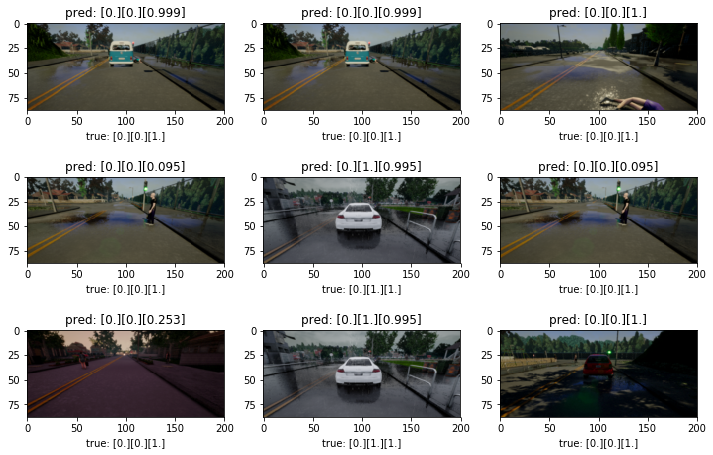

In [130]:
plt.figure(figsize=(12, 8))
sample = np.random.randint(0, iters, 9)
sample = np.random.choice(np.where(x_test_stop_pedestrian[:iters].numpy() == 1.0)[0], 9)
for p, i in enumerate(sample):
    plt.subplot(3, 3, p+1)
    plt.imshow(x_test_camera[i].permute(1, 2, 0).numpy())
    title = "pred: " + str(np.round(preds_traffic_light[i])) + \
                str(np.round(preds_vehicle[i])) + \
                str(np.round(preds_pedestrian[i], 3))
    xlabel = "true: " + str(x_test_stop_traffic_lights[i].numpy()) + \
                str(x_test_stop_vehicle[i].numpy()) + \
                str(x_test_stop_pedestrian[i].numpy())
    plt.title(title)
    plt.xlabel(xlabel)